# Import libraries

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn

if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
else:
    print("No GPU available")



NVIDIA GeForce GTX 1660 SUPER


# Load data & model

In [73]:
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle = True)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle = True)


In [74]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, kernel_size=5, stride=1, padding=2)
        # self.bn1 = nn.BatchNorm2d(5)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(5, 5, kernel_size=5, stride=1, padding=2)
        # self.bn2 = nn.BatchNorm2d(5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv2d(5, 10, kernel_size=5, stride=1, padding=2)
        # self.bn3 = nn.BatchNorm2d(10)
        self.fc1 = nn.Linear(10*7*7, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        x = F.relu(self.conv3(x))
        x = self.dropout(x)
        
        x = x.view(-1, 10*7*7)
        x = self.fc1(x)
        return x

model = Model()

model.load_state_dict(torch.load('mnist_model.pth', weights_only=True))


<All keys matched successfully>

# Define LRP class

In [106]:
class LRP:
    def __init__(self, model, epsilon=1e-9):
        self.model = model
        self.model.eval()
        self.epsilon = epsilon

    def fc_layer_relevance(self, layer, input_data, relevance):
        w = layer.weight
        b = layer.bias if layer.bias is not None else torch.zeros(layer.out_features)
        
        z = torch.mm(input_data, w.t()) + b
        z = z + self.epsilon * torch.sign(z)
        s = relevance / z
        c = torch.mm(s, w)
        r = input_data * c
        
        return r
        
    def deconvolution(self, conv_layer, input_data, relevance):
        z = F.conv2d(
            input_data,
            weight=conv_layer.weight,
            bias=conv_layer.bias,
            stride=conv_layer.stride,
            padding=conv_layer.padding
        )
        # Relevance를 입력에 비례 분배
        z = torch.clamp(z, min=0)
        z = z + self.epsilon * torch.sign(z)
        Z_j = z.sum(dim=(2,3), keepdim=True)  # 공간 차원 합산
        s = (z / Z_j) * relevance
        c = F.conv_transpose2d(
            s,
            weight=conv_layer.weight,
            stride=conv_layer.stride,
            padding=conv_layer.padding
        )
    
        # 입력 relevance 계산
        r = input_data * c
        return r

    
    def unpool(self, pool_layer, input_data, relevance):
        # Forward pass에서 max pooling의 결과와 인덱스를 획득
        pooled_output, indices = F.max_pool2d_with_indices(
            input_data,
            kernel_size=pool_layer.kernel_size,
            stride=pool_layer.stride,
            padding=pool_layer.padding,
        )
    
        # Max Unpooling으로 relevance를 원래 크기로 복원
        restored_relevance = F.max_unpool2d(
            relevance,
            indices,
            kernel_size=pool_layer.kernel_size,
            stride=pool_layer.stride,
            padding=pool_layer.padding,
        )
    
        # Relevance 보존 조정
        # 원래 크기로 복원된 relevance의 합과 원래 relevance의 합을 동일하게 맞춤
        in_sum = restored_relevance.sum() + self.epsilon
        out_sum = relevance.sum() + self.epsilon
        scaling_factor = out_sum / in_sum
        restored_relevance *= scaling_factor

        return restored_relevance
    
    def compute_relevance(self, input_data, target_class):
        activations = []
        x = input_data.unsqueeze(0)
        
        def hook_fn(module, input, output):
            activations.append(input[0].detach())
        
        hooks = []
        layers = []
        layer_names = []
        for name, module in self.model.named_modules():
            if isinstance(module, (nn.Conv2d, nn.MaxPool2d, nn.Linear)):
                hooks.append(module.register_forward_hook(hook_fn))
                layers.append(module)
                layer_names.append(name)
        # print(f'layer_names: {layer_names}')
        try:
            output = self.model(x)
            
            # Initialize relevance with target class
            relevance = torch.zeros_like(output)
            relevance[0, target_class] = output[0, target_class]

            # Backward pass (LRP)
            for i in range(len(activations) - 1, -1, -1):
                layer = layers[i]
                
                if isinstance(layer, nn.Linear):
                    relevance = self.fc_layer_relevance(layer, activations[i], relevance)
                
                elif isinstance(layer, nn.Conv2d):
                    if len(relevance.shape) == 2:  # FC layer에서 온 경우
                        relevance = relevance.view(-1,10,7,7)
                    relevance = self.deconvolution(layer, activations[i], relevance)
                    
                elif isinstance(layer, nn.MaxPool2d):
                    relevance = self.unpool(layer, activations[i], relevance)
            return relevance
            
        finally:
            for hook in hooks:
                hook.remove()

def visualize_lrp(model, image, target_class):
    lrp = LRP(model)
        
    relevance = lrp.compute_relevance(image, target_class)
    relevance = relevance.squeeze().detach().numpy()
    image = image.squeeze().numpy()
    
    return image, relevance


target_class: 6


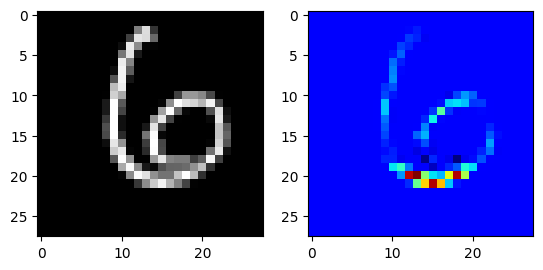

[[-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
   0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  -0.000

In [108]:
index = 100  # 테스트할 이미지 인덱스
image = test_loader.dataset[index][0]
target_class = test_loader.dataset[index][1]
print(f'target_class: {target_class}')
image, relevance = visualize_lrp(model, image, target_class)

plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(relevance, cmap=plt.cm.jet)
plt.show()


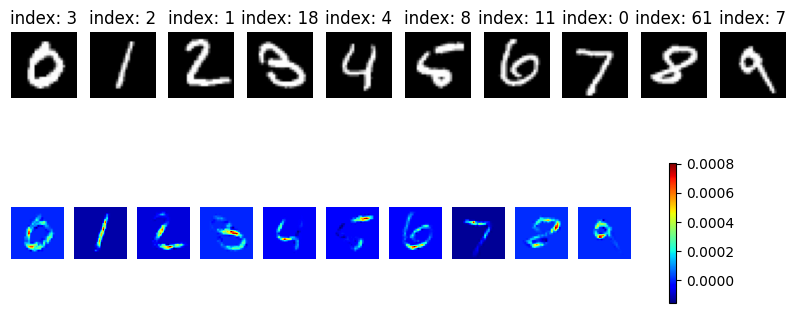

In [109]:
fig, axes = plt.subplots(2, 10, figsize=(10,4))
for i in range(10):
    j = 0
    while test_loader.dataset[j][1] != i:
        j += 1
    image, relevance = visualize_lrp(model, test_loader.dataset[j][0], i)
    axes[0, i].imshow(image, cmap='gray')
    axes[0, i].set_title(f'index: {j}')
    axes[0, i].axis('off')
    img = axes[1, i].imshow(relevance, cmap=plt.cm.jet)
    axes[1, i].axis('off')
fig.colorbar(img, ax=axes[1, :], location='right')
plt.show()

